In [3]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import difflib

from transformers import AutoTokenizer

CORPUS_FILE = "20231109_gender_bias_dataset.csv"

plt.style.use("seaborn-v0_8")

# Corpus

In [4]:
df = pd.read_csv(f"../../data/processed/{CORPUS_FILE}")
print(df.shape)
df.head(2)

(31195, 2)


,input,target
0,"Chilkatufe UChile mew, estudiantes mapuche U. ...","Chilkatufe UChile mew, estudiantes mapuche U. ..."
1,"Biblioteca Central, FCFM Académicas mapuche, FCFM","Biblioteca Central, FCFM Académicas mapuche, FCFM"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31195 entries, 0 to 31194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   31195 non-null  object
 1   target  31195 non-null  object
dtypes: object(2)
memory usage: 487.5+ KB


# Exploration

## Sequence Length

### FLAN

In [80]:
flan_tok = AutoTokenizer.from_pretrained("google/flan-t5-large")

In [10]:
input_tokens = pd.Series([
    i
    for i in flan_tok(df["input"].to_list())["input_ids"]
])

input_tokens_len = pd.Series([
    len(i)
    for i in input_tokens
])

print(input_tokens_len.quantile(0.99))
input_tokens_len.describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


241.0


count    31195.000000
mean        80.405642
std         48.989391
min         20.000000
25%         48.000000
50%         69.000000
75%        100.000000
max       2625.000000
dtype: float64

In [11]:
target_tokens_len = pd.Series([
    len(i)
    for i in flan_tok(df["target"].to_list())["input_ids"]
])
print(target_tokens_len.quantile(0.99))
target_tokens_len.describe()

224.0


count    31195.000000
mean        62.856483
std         49.345723
min          2.000000
25%         30.000000
50%         52.000000
75%         83.000000
max       2607.000000
dtype: float64

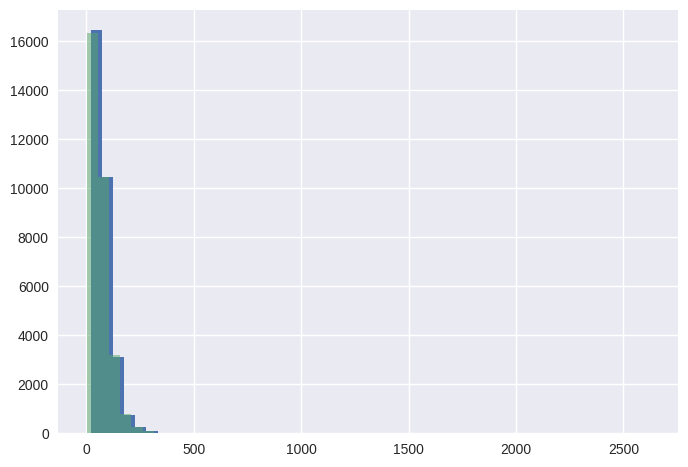

In [12]:
plt.hist(input_tokens_len, bins=50)
plt.hist(target_tokens_len, alpha=0.5, bins=50);

### Falcon

In [4]:
falcon_tok = AutoTokenizer.from_pretrained("vilsonrodrigues/falcon-7b-instruct-sharded")

In [66]:
input_tokens = pd.Series([
    i
    for i in falcon_tok(df["input"].to_list())["input_ids"]
])

input_tokens_len = pd.Series([
    len(i)
    for i in input_tokens
])

print(input_tokens_len.quantile(0.99))
input_tokens_len.describe()

163.0


count    31195.000000
mean        43.921494
std         36.719875
min          1.000000
25%         21.000000
50%         36.000000
75%         57.000000
max       2448.000000
dtype: float64

## BoW

### FLAN

In [22]:
input_token_decoded = pd.Series([
    flan_tok.decode(i)
    for i in input_tokens
]).tolist()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(input_token_decoded)

df_frec = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

df_total_frec = pd.DataFrame({
    'token': vectorizer.get_feature_names_out(),
    'counts': df_frec.sum()
}).sort_values(by='counts', ascending=False)

df_total_frec["relative"] = df_total_frec["counts"] / df_total_frec["counts"].sum() * 100

df_total_frec.head(10).T

,de,unk,la,el,en,que,los,las,se,para
token,de,unk,la,el,en,que,los,las,se,para
counts,59476,28022,24413,19904,18583,12701,10137,9614,9071,8265
relative,8.318682,3.919331,3.414554,2.783897,2.599134,1.776441,1.417824,1.344674,1.268726,1.155994


In [23]:
differ = difflib.Differ()
unknown_subwords = []

for i, input in enumerate(df["input"]):
    input_tokens_dec = flan_tok.decode(input_tokens[i], skip_special_tokens=False)

    if "<unk>" in input_tokens_dec:
        input_lines = input.split()
        dec_lines = input_tokens_dec.replace("</s>", "").split()
        diff = list(differ.compare(input_lines, dec_lines))

        unk_sw = [
            list(set(line[2:]) - set(input_tokens_dec))
            for line in diff if line.startswith('- ')
        ]
        
        unknown_subwords += [i[0] for i in unk_sw if len(i)]

counter = pd.DataFrame.from_dict(
    Counter(unknown_subwords),
    orient="index",
    columns=["Frequency"]
).sort_values(by=["Frequency"], ascending=False)

print(counter.head(20).index)
counter.head(20).T

Index(['í', 'ñ', 'ú', 'Á', '¡', '¿', 'Í', '', '', 'Ó', '', '​', '', 'º',
       '·', 'Ñ', 'Ú', '́', '', '✔'],
      dtype='object')


,í,ñ,ú,Á,¡,¿,Í,,,Ó,,​,,º,·,Ñ,Ú,́,,✔
Frequency,15311,4116,2461,759,757,728,620,616,573,347,306,284,275,244,128,107,102,95,85,43


In [82]:
encoding_new_t = flan_tok("beauchefianos Física", return_tensors="pt")
print(encoding_new_t["input_ids"])
print(flan_tok.decode(encoding_new_t["input_ids"][0], skip_special_tokens=False))
print([flan_tok.decode(t) for t in encoding_new_t["input_ids"][0]])

tensor([[ 9743,  1033,    89, 20028,     7,   377,     2,     7,  2617,     1]])
beauchefianos F<unk>sica</s>
['beau', 'che', 'f', 'iano', 's', 'F', '<unk>', 's', 'ica', '</s>']


### Falcon

In [67]:
input_token_decoded = pd.Series([
    falcon_tok.decode(i)
    for i in input_tokens
]).tolist()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(input_token_decoded)

df_frec = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

df_total_frec = pd.DataFrame({
    'token': vectorizer.get_feature_names_out(),
    'counts': df_frec.sum()
}).sort_values(by='counts', ascending=False)

df_total_frec["relative"] = df_total_frec["counts"] / df_total_frec["counts"].sum() * 100

df_total_frec.head(10).T

,de,la,el,en,que,los,las,se,para,del
token,de,la,el,en,que,los,las,se,para,del
counts,59487,24432,19911,18562,12705,10137,9617,8899,8267,8020
relative,8.689955,3.569065,2.90863,2.711566,1.855966,1.480829,1.404867,1.29998,1.207656,1.171574


In [78]:
palabras = list(df_total_frec.T.columns)
[
    p
    for p in palabras
    if "<" in p
]

[]